In [1]:
# Imports
import sys
from time import time

from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist as data

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from mlxtend.evaluate import confusion_matrix

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
# Precision score
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
        
# Recall score
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

# F-score
def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [3]:
def plotgraph(history):
        # categorical accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # categorical loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # top_k_categorical_accuracy
        plt.plot(history.history['top_k_categorical_accuracy'])
        plt.plot(history.history['val_top_k_categorical_accuracy'])
        plt.title('model top_k_categorical_accuracy')
        plt.ylabel('top_k_categorical_accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # sparse_categorical_accuracy
        plt.plot(history.history['sparse_categorical_accuracy'])
        plt.plot(history.history['val_sparse_categorical_accuracy'])
        plt.title('model sparse_categorical_accuracy')
        plt.ylabel('sparse_categorical_accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # recall
        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('model recall')
        plt.ylabel('recall')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # fmeasure
        plt.plot(history.history['fmeasure'])
        plt.plot(history.history['val_fmeasure'])
        plt.title('model fmeasure')
        plt.ylabel('fmeasure')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [7]:
class LSTMClassifier(object):
    def __init__(self):
        # Classifier
        self.time_steps=28 # timesteps to unroll
        self.n_units=128 # hidden LSTM units
        self.n_inputs=28 # rows of 28 pixels (an mnist img is 28x28)
        self.n_classes=10 # mnist classes/labels (0-9)
        self.batch_size=128 # Size of each batch
        self.n_epochs=20
        # Internal
        self._data_loaded = False
        self._trained = False
    
    def __create_model(self):
        self.model = Sequential()
        self.model.add(LSTM(self.n_units, input_shape=(self.time_steps, self.n_inputs)))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(self.n_classes, activation='softmax'))

        self.model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                      metrics=['accuracy', 'sparse_categorical_accuracy',
                           'top_k_categorical_accuracy', recall, fmeasure])
        self.tensorboard = TensorBoard(log_dir="logs/lstm".format(time()))

    def __load_data(self):
        self.mnist = input_data.read_data_sets("mnist", one_hot=True)
        self._data_loaded = True
        
    def train(self, save_model=False):
        self.__create_model()
        if self._data_loaded == False:
            self.__load_data()
        
        (X_train, y_train), (X_test, y_test) = data.load_data()
        mapper = y_test

        x_train = [x.reshape((-1, self.time_steps, self.n_inputs)) for x in self.mnist.train.images]
        x_train = np.array(x_train).reshape((-1, self.time_steps, self.n_inputs))
        
        x_test = [x.reshape((-1, self.time_steps, self.n_inputs)) for x in self.mnist.test.images]
        x_test = np.array(x_test).reshape((-1, self.time_steps, self.n_inputs))
        
        self.history = self.model.fit(x_train, self.mnist.train.labels,validation_data=(x_test, self.mnist.test.labels),
                  batch_size=self.batch_size, epochs=self.n_epochs, shuffle=False, callbacks=[self.tensorboard])

        self._trained = True
        
        if save_model:
            self.model.save("lstm-model.h5")
        
        plotgraph(self.history)
        rounded_prediction = self.model.predict_classes(x_test, batch_size=10, verbose=0)
        print(rounded_prediction)
        cm = confusion_matrix(y_target=mapper, y_predicted=rounded_prediction, binary=False)
        print(cm)
        arr = np.array(cm)
        df = pd.DataFrame(arr, index=[i for i in "0123456789"],
                          columns=[i for i in "0123456789"])
        plt.figure(figsize=(13, 10))
        seaborn.heatmap(df, annot=True, cmap="YlGnBu", fmt='d')
        plt.show()

    def evaluate(self, model=None):
        if self._trained == False and model == None:
            errmsg = "[!] Error: classifier wasn't trained or classifier path is not precised."
            print(errmsg, file=sys.stderr)
            sys.exit(0)

        if self._data_loaded == False:
            self.__load_data()

        x_test = [x.reshape((-1, self.time_steps, self.n_inputs)) for x in self.mnist.test.images]
        x_test = np.array(x_test).reshape((-1, self.time_steps, self.n_inputs))

        model = load_model(model) if model else self.model
        test_loss = model.evaluate(x_test, self.mnist.test.labels)
        print("LSTM Error: %.2f%%" % (100-test_loss[1]*100))
        
    def _print_summary(self):
        self.model.summary()

In [8]:
lstm_classifier = LSTMClassifier()

Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz
Train on 55000 samples, validate on 10000 samples
Epoch 1/20
55000/55000 [==============================] - 60s 1ms/step - loss: 0.6692 - acc: 0.7766 - sparse_categorical_accuracy: 0.1182 - top_k_categorical_accuracy: 0.9730 - recall: 0.6981 - fmeasure: 0.7482 - val_loss: 0.4496 - val_acc: 0.8631 - val_sparse_categorical_accuracy: 0.1139 - val_top_k_categorical_accuracy: 0.9931 - val_recall: 0.8518 - val_fmeasure: 0.8663
Epoch 2/20
55000/55000 [==============================] - 56s 1ms/step - loss: 0.1970 - acc: 0.9390 - sparse_categorical_accuracy: 0.1121 - top_k_categorical_accuracy: 0.9980 - recall: 0.9305 - fmeasure: 0.9397 - val_loss: 0.4195 - val_acc: 0.8845 - val_sparse_categorical_accuracy: 0.1140 - val_top_k_categorical_accuracy: 0.9962 - val_recall: 0.8762 - val_fmeasure: 0.8846
Epoch 3/20
55000/55000 [==

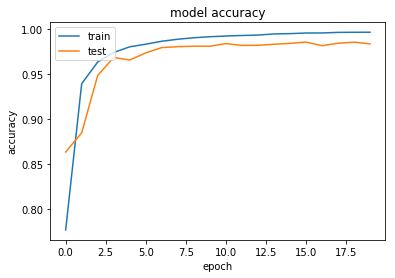

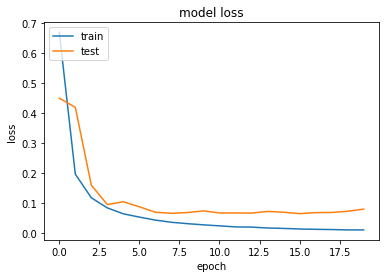

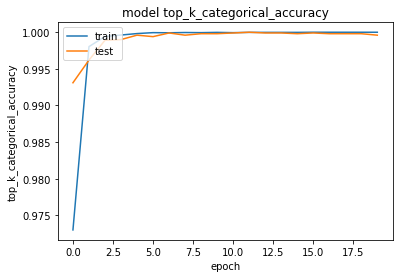

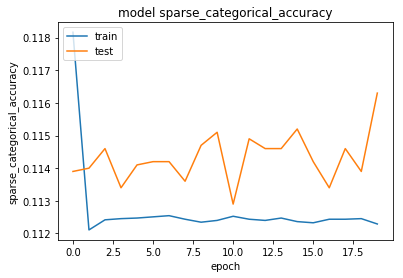

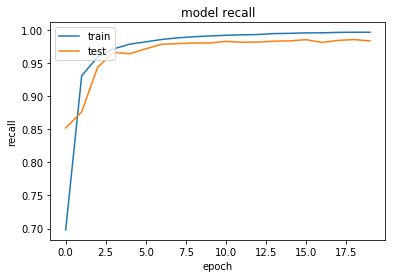

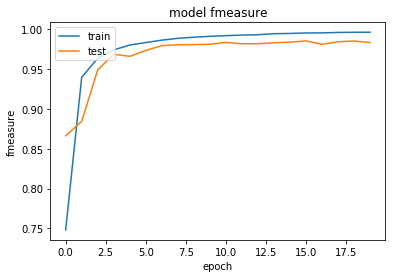

[7 2 1 ..., 4 5 6]
[[ 978    0    0    0    0    0    0    2    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   5    3 1010    3    2    0    0    4    4    1]
 [   0    0    2  996    0    4    0    2    2    4]
 [   0    2    0    0  955    1    5    2    3   14]
 [   2    0    1    6    0  871    4    1    4    3]
 [   2    2    0    0    1    1  951    0    1    0]
 [   0   17    6    0    7    0    0  996    1    1]
 [   5    3    2    3    1    1    3    3  950    3]
 [   0    2    0    0    5    0    1    5    4  992]]


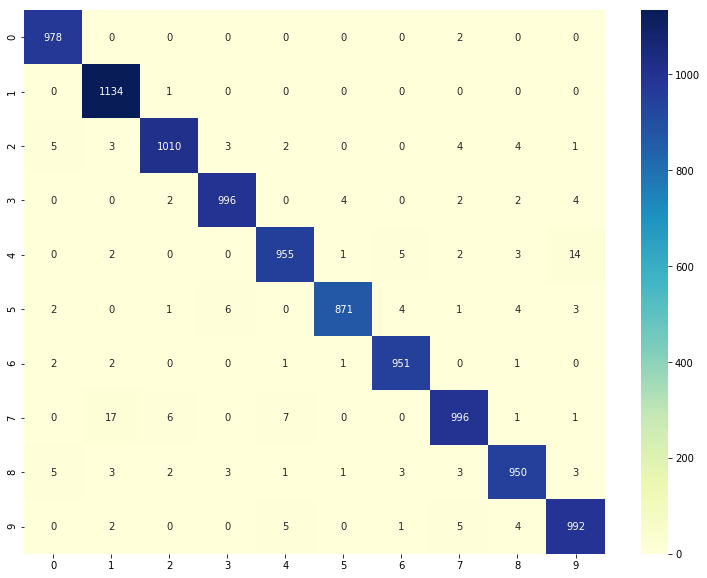

In [9]:
lstm_classifier.train(save_model=True)

In [10]:
lstm_classifier._print_summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 98,186
Trainable params: 98,186
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm_classifier.evaluate()

10000/10000 [==============================] - 5s 528us/step
LSTM Error: 1.67%
